In [11]:
import json
import os
from glob import glob
from subprocess import call
import time
import nibabel
import numpy as np
from joblib import Parallel, delayed
from skimage.exposure import rescale_intensity
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt

/tmp/ipykernel_57471/3411625526.py:10: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


### Data Preparation

In [12]:
import concurrent.futures

# Preparing the data for the model
def get_folder_paths(directory):
    folder_paths = [os.path.join(directory, folder) for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folder_paths


# Function to load a NIfTI file
def load_nifty(directory, example_id, suffix):
    return nibabel.load(os.path.join(directory, example_id + "_" + suffix + ".nii.gz"))

# Function to load all sequences for a given example
def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["flair", "t1", "t1ce", "t2"]]

# Function to get data from a NIfTI file
def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)

# Function to prepare a NIfTI file
def prepare_nifty(d):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = t1.affine, t1.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
    nibabel.save(vol, os.path.join(d, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "_seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        # changing label 4 with 3 (for Brats dataset)
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
        nibabel.save(seg, os.path.join(d, example_id + "_seg.nii.gz"))

# making the model's required file structure
def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "images"), os.path.join(data, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)


    dirs = glob(os.path.join(data, "BraTS*"))    #hard code
    # dirs = glob(os.path.join(data, "ASH*"))
    for d in dirs:
        if "_" in d.split("/")[-1]:
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "flair" in f or "t1" in f or "t1ce" in f or "t2" in f:
                    continue
                if "_seg" in f:
                    call(f"mv {f} {lbl_path}", shell=True)
                else:
                    call(f"mv {f} {img_path}", shell=True)
        call(f"rm -rf {d}", shell=True)


# making the model's required json file
def prepare_dataset_json(data, train):
    images, labels = glob(os.path.join(data, "images", "*")), glob(os.path.join(data, "labels", "*"))
    images = sorted([img.replace(data + "/", "") for img in images])
    labels = sorted([lbl.replace(data + "/", "") for lbl in labels])

    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}
    if train:
        key = "training"
        print("images", images)
        print("labels", labels)
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)

# Function to run a function in parallel
def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)
        

# def run_parallel(func, args):
#     with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
#         results = list(executor.map(func, args))
#     return results        

# Main function to prepare the dataset
def prepare_dataset(data, train):
    print(f"Preparing BraTS21 dataset from: {data}")
    start = time.time()
    run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "BraTS*"))))   #hard code
    # run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "ASH*"))))
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")


In [13]:
# this path '/content/drive/MyDrive/data/BraTS2021_train' should contain the folder containig the data with the ground truth (T1,T2,T1ce,flair,seg)
prepare_dataset("/home/workstation04/GP_MMMAI/validation_samples", True)
print("Finished!")

Preparing BraTS21 dataset from: /home/workstation04/GP_MMMAI/validation_samples
images ['images/BraTS2021_00000.nii.gz', 'images/BraTS2021_00009.nii.gz', 'images/BraTS2021_00016.nii.gz', 'images/BraTS2021_00024.nii.gz', 'images/BraTS2021_00028.nii.gz', 'images/BraTS2021_00031.nii.gz', 'images/BraTS2021_00035.nii.gz', 'images/BraTS2021_00045.nii.gz', 'images/BraTS2021_00046.nii.gz', 'images/BraTS2021_00051.nii.gz', 'images/BraTS2021_00070.nii.gz', 'images/BraTS2021_00078.nii.gz', 'images/BraTS2021_00085.nii.gz', 'images/BraTS2021_00087.nii.gz', 'images/BraTS2021_00088.nii.gz', 'images/BraTS2021_00089.nii.gz', 'images/BraTS2021_00099.nii.gz', 'images/BraTS2021_00102.nii.gz', 'images/BraTS2021_00104.nii.gz', 'images/BraTS2021_00106.nii.gz', 'images/BraTS2021_00107.nii.gz', 'images/BraTS2021_00110.nii.gz', 'images/BraTS2021_00117.nii.gz', 'images/BraTS2021_00123.nii.gz', 'images/BraTS2021_00126.nii.gz', 'images/BraTS2021_00127.nii.gz', 'images/BraTS2021_00130.nii.gz', 'images/BraTS2021_001

In [14]:
import json

# Specify the path to your JSON file
json_file_path = '/home/workstation04/GP_MMMAI/data/BraTS2021_train/dataset.json'

# Open the JSON file and load its contents
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)
len(data['training'])

251

### Data Preprocessing

In [7]:
!python3 /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/preprocess.py -h

2024-02-03 18:34:05.301883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 18:34:05.301925: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 18:34:05.301959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 18:34:05.308388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 18:34:06.016377: W tensorflow/compiler/

In [15]:
# Preprocessing the data (NVIDIA nnUNet)
# task 11 is set for brats
# change exec_mode to val --> wont expect seg
!python3 /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/preprocess.py --task 11  --exec_mode training --data "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/val_set/data" --results "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/val_set" --ohe

print("Finished!")

2024-02-12 08:55:23.231016: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 08:55:23.231058: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 08:55:23.231239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 08:55:23.262065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 08:55:24.254113: W tensorflow/compiler/

In [ ]:
# Preprocessing (3D UNet) / without one hot encoding (--ohe)
!python3 /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/preprocess.py --task 11  --exec_mode training --data "/content/drive/MyDrive/data" --results "/content/drive/MyDrive/data"
print("Finished!")

In [29]:
import pickle
with open('/home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/data/11_3d/config.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)

{'patch_size': [128, 128, 128], 'spacings': [1.0, 1.0, 1.0], 'n_class': 4, 'in_channels': 5}


### Inference

in case of this error ModuleNotFoundError: No module named 'nnunet.nn_unet'
execute this command
``` bash
touch /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/nnunet/__init__.py
```


### Validation set

In [20]:
# Prediction (NVIDIA nnUNet)
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --exec_mode "predict" --gpus 1 --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --amp --save_preds --task 11 --data "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/dataValidation/11_3d" --ckpt_path "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/before/checkpoints/epoch=13-dice=81.48.ckpt" --results "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/before/resultsValidation" --tta


2024-02-12 09:09:48.238531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 09:09:48.238574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 09:09:48.238615: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 09:09:48.245840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 09:09:49.014709: W tensorflow/compiler/

In [21]:
# Prediction (NVIDIA nnUNet)
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --exec_mode "predict" --gpus 1 --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --amp --save_preds --task 11 --data "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/dataValidation/11_3d" --ckpt_path "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/with/checkpoints/epoch=13-dice=80.90.ckpt" --results "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/with/resultsValidation" --tta


2024-02-12 11:06:03.662196: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 11:06:03.662244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 11:06:03.662292: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 11:06:03.670738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 11:06:04.757228: W tensorflow/compiler/

In [22]:
# Prediction (NVIDIA nnUNet)
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --exec_mode "predict" --gpus 1 --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --amp --save_preds --task 11 --data "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/dataValidation/11_3d" --ckpt_path "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/without/checkpoints/epoch=11-dice=80.42.ckpt" --results "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/without/resultsValidation" --tta


2024-02-12 13:07:38.434524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 13:07:38.434573: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 13:07:38.434620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 13:07:38.443286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 13:07:39.544693: W tensorflow/compiler/

-------------------------------------------
### Test set

In [23]:
# with
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --exec_mode "predict" --gpus 1 --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --amp --save_preds --task 11 --data "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/test_set/11_3d" --ckpt_path "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/fineTuning/with/checkpoints/epoch=8-dice=82.50.ckpt" --results "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/fineTuning/with/test_results" --tta


2024-02-14 10:15:27.652360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 10:15:27.652409: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 10:15:27.652454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 10:15:27.660118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 10:15:28.730732: W tensorflow/compiler/

In [24]:
# without
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --exec_mode "predict" --gpus 1 --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --amp --save_preds --task 11 --data "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/test_set/11_3d" --ckpt_path "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/fineTuning/without/checkpoints/epoch=13-dice=82.50.ckpt" --results "/media/workstation04/New Volume/MMMAI/NVIDIA_TRIAL2/fineTuning/without/test_results" --tta


2024-02-14 10:21:21.985736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 10:21:21.985783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 10:21:21.985826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 10:21:21.994103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 10:21:22.841552: W tensorflow/compiler/

---------------------

In [17]:
# Prediction (NVIDIA nnUNet)
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --exec_mode "predict" --gpus 1 --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --amp --save_preds --task 11 --data "/media/workstation04/New Volume/MMMAI/trial/data/11_3d" --ckpt_path "/media/workstation04/New Volume/MMMAI/trial/checkpoints/epoch=0-dice=87.97.ckpt" --results "/media/workstation04/New Volume/MMMAI/trial" --tta


2024-02-06 21:06:42.185340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 21:06:42.185381: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 21:06:42.185415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 21:06:42.191717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 21:06:42.957836: W tensorflow/compiler/

In [3]:
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --exec_mode "predict" --gpus 1 --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --amp --save_preds --task 11 --data "/media/workstation04/New Volume/MMMAI/data/11_3d" --ckpt_path "/media/workstation04/New Volume/MMMAI/without_AL/checkpoints/epoch=8-dice=84.02.ckpt" --results "/media/workstation04/New Volume/MMMAI/data" --tta


2024-02-06 17:56:24.148217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 17:56:24.148269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 17:56:24.148307: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 17:56:24.154721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 17:56:24.903838: W tensorflow/compiler/

In [11]:
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --exec_mode "predict" --gpus 1 --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --amp --save_preds --task 11 --data "/media/workstation04/New Volume/MMMAI/data/11_3d" --ckpt_path "/media/workstation04/New Volume/MMMAI/NVIDIA_TRAIN/new_ckpt/checkpoints/epoch=1-dice=83.78.ckpt" --results "/media/workstation04/New Volume/MMMAI/data" --tta


2024-02-05 19:50:27.971920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 19:50:27.971961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 19:50:27.971999: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 19:50:27.979509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 19:50:28.967421: W tensorflow/compiler/

In [21]:
!python /home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py -h

<frozen importlib._bootstrap>:228: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject
2024-02-03 18:06:05.766834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 18:06:05.766872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 18:06:05.766912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 18:06

In [1]:
# Prediction (3D UNet) --> you need to replace the code in /content/DeepLearningExamples/PyTorch/Segmentation/nnUNet/nnunet/brats22_model.py with the 3D UNet code in https://github.com/A-shazli/Brain_Tumor_seg_GP/blob/main/segmentation/unet3d_brain.py
!python /content/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --brats22_model --exec_mode "predict" --gpus 1 --amp --save_preds --task 11 --data "/content/drive/MyDrive/data/11_3d" --ckpt_path "/content/drive/MyDrive/results_u-net3d/checkpoints/last.ckpt" --results "/content/drive/MyDrive/outputfolder" --tta

python: can't open file '/content/DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py': [Errno 2] No such file or directory


In [18]:
# The prediction will produce a npy file containing the probability to belong to a class for each voxel
# so we need to set each voxel to the class with the highest probability
# and then save the segmentation as nifti file

# Function to set each voxel to the class with the highest probability
def to_lbl(pred):
    # pred.shape = (num_classes, depth , height, width)
    print(pred.shape)
    pred = np.argmax(pred, axis=0)
    # Transpose to be  (height, width, depth)
    pred = np.transpose(pred, (2, 1, 0)).astype(np.uint8)
    print(pred.shape)
    return pred

# Function to save the predicted segmentation as nifti file
def prepare_preditions(e):
    fname = e[0].split("/")[-1].split(".")[0]
    preds = [np.load(f) for f in e]
    p = to_lbl(np.mean(preds, 0))


    # img is the input volumes stacked together ,needed so that the saved prediction have the same affine (map voxel coordinates to real-world coordinates) and header (contains metadata information about the image)
    img = nibabel.load(f"/media/workstation04/New Volume/MMMAI/trial/data/BraTS2021_train/images/{fname}.nii.gz")
    nibabel.save(
        nibabel.Nifti1Image(p, img.affine, header=img.header),
        os.path.join("/media/workstation04/New Volume/MMMAI/trial", fname + ".nii.gz"),
    )

In [19]:
preds = sorted(glob(f"/media/workstation04/New Volume/MMMAI/trial/predictions_epoch=0-dice=87_97_task=11_fold=0_tta*"))
examples = list(zip(*[sorted(glob(f"{p}/*.npy")) for p in preds]))
print("Preparing final predictions")
for e in examples:
    prepare_preditions(e)
print("Finished!")

Preparing final predictions
(4, 155, 240, 240)
(240, 240, 155)
Finished!


In [37]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

path = '/home/workstation04/GP_MMMAI/Notebooks/NVIDIA_nnUNet/data/BraTS2021_00002.nii.gz'
Nifti_img  = nib.load(path)
nii_data = Nifti_img.get_fdata()
print(np.unique(nii_data))
print(nii_data.shape)


[0. 1. 2. 3.]
(240, 240, 155)


### Uncertainty Estimation and Visualization

In [ ]:
# Get the list of file names in the folder
file_names = os.listdir('/content/drive/MyDrive/data/BraTS2021_train/images')

# Check if there are files in the folder
if file_names:
    # Get the name of the first file
    file_name = file_names[0].split(".")[0]

# Load the probability data
probability_path = f'/content/drive/MyDrive/data/predictions_epoch=7-dice=84_40_task=11_fold=0_tta/{file_name}.npy'
tensor = np.load(probability_path, allow_pickle=True)  # Shape: (num_classes, depth, height, width)

# Load the input NIfTI file
input_path =f'/content/drive/MyDrive/data/BraTS2021_train/images/{file_name}.nii.gz'
input_data = nibabel.load(input_path).get_fdata()  # Shape: (height, width, depth, num_classes)
input_data = np.transpose(input_data, (1, 0, 2,3))

# Load the segmentation NIfTI file
segmentation_path = f'/content/drive/MyDrive/data/BraTS2021_train/labels/{file_name}_seg.nii.gz'
segmentation_data = nibabel.load(segmentation_path).get_fdata()  # Shape: (height, width, depth)
segmentation_data = np.transpose(segmentation_data, (1, 0, 2))

# Load the Prediction NIfTI file
prediction_path = f'/content/drive/MyDrive/data/{file_name}.nii.gz'
prediction_data = nibabel.load(prediction_path).get_fdata()  # Shape: (height, width, depth)
prediction_data = np.transpose(prediction_data, (1, 0, 2))


### Estimating The Model Uncertainty Using The Entropy

In [ ]:
# Calculate uncertainty (entropy) from probabilities
def compute_entropy(tensor):
    sum_tensor = np.sum(tensor, axis=0, keepdims=True)
    tensor_normalized = tensor / (sum_tensor + 1e-12)  # Added a small value to avoid division by zero
    entropy_elements = -tensor_normalized * np.log2(tensor_normalized + 1e-12)  # Added a small value to avoid log(0)
    entropy = np.sum(entropy_elements, axis=0)


    # Get the maximum and minimum values
    max_value = np.max(entropy)
    min_value = np.min(entropy)

    print("Maximum value:", max_value)
    print("Minimum value:", min_value)
    entropy = np.transpose(entropy, (2,1,0))
    total_entropy = np.sum(entropy)



    return entropy, total_entropy

### Visualizing The Model Uncertainty

Maximum value: 1.999999999993672
Minimum value: 2.372624761181625e-11
total_entropy: 12404127.438627068


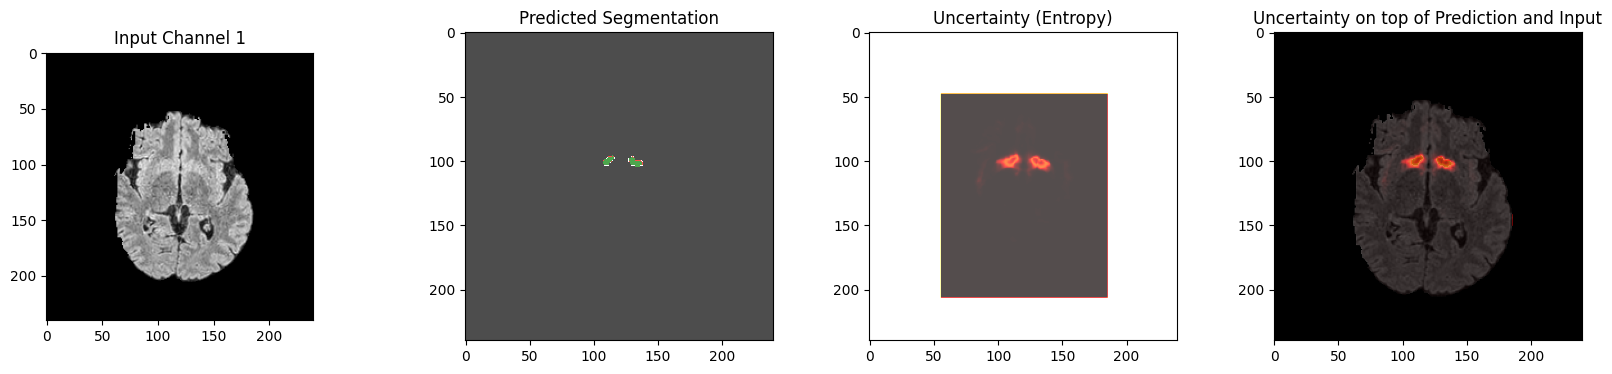

In [ ]:
entropy_data, total_entropy = compute_entropy(tensor)
print("total_entropy:", total_entropy)
entropy_data = np.transpose(entropy_data, (1, 0, 2))

# Visualize uncertainty on a slice
slice_index = 67  # Choose a slice index for visualization

# Create a figure with five subplots
plt.figure(figsize=(20, 4))
labels = ['background', 'edema', 'necrosis', 'enhancing tumor']
colors = ['black',  'white',  'red', 'green']

cmap = ListedColormap(colors) # Define the colormap
# Choose the channel to visualize
channel_to_visualize = 0  # Adjust this value based on your preference

# Visualize the input volume for the selected channel
plt.subplot(1, 5, 1)
plt.imshow(input_data[:, :, slice_index, channel_to_visualize], cmap='gray')
plt.title(f'Input Channel {channel_to_visualize + 1}')

# # Plot the segmentation
# plt.subplot(1, 5, 2)
# plt.imshow(segmentation_data[:, :, slice_index], cmap='viridis', alpha=0.7)
# plt.title('Ground Truth Segmentation')

# Plot the prediction
plt.subplot(1, 4, 2)
plt.imshow(prediction_data[:, :, slice_index], cmap=cmap, alpha=0.7)
plt.title('Predicted Segmentation')

# Plot the uncertainty
plt.subplot(1, 4, 3)
plt.imshow(entropy_data[:, :, slice_index], cmap='hot', alpha=0.7)
plt.title('Uncertainty (Entropy)')

# Plot the uncertainty on top of the prediction and input data
plt.subplot(1, 4, 4)
# Set the alpha channel of uncertainty to zero where the background is black
alpha_channel = np.where(input_data[:, :, slice_index, channel_to_visualize] == 0, 0, 0.7)
alpha_channel2 = np.where(prediction_data[:, :, slice_index] == 0, 0, 0.7)

plt.imshow(input_data[:, :, slice_index, channel_to_visualize], cmap='gray')
plt.imshow(prediction_data[:, :, slice_index], cmap=cmap, alpha= alpha_channel2)
plt.imshow(entropy_data[:, :, slice_index], cmap='hot', alpha=alpha_channel)
plt.title('Uncertainty on top of Prediction and Input')
plt.show()

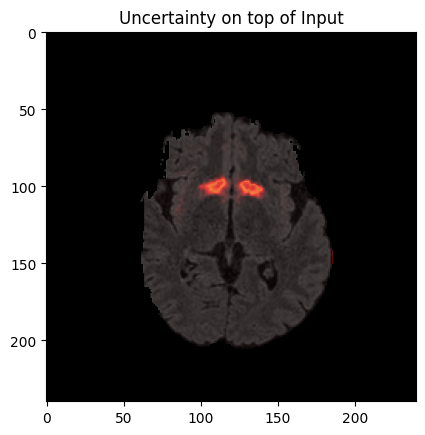

In [ ]:
# Assuming you have defined alpha_channel as mentioned before
alpha_channel = np.where(input_data[:, :, slice_index, channel_to_visualize] == 0, 0, 0.7)
plt.imshow(input_data[:, :, slice_index, channel_to_visualize], cmap='gray')
plt.imshow(entropy_data[:, :, slice_index], cmap='hot', alpha=alpha_channel)
plt.title('Uncertainty on top of Input')
plt.show()